In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import Formatter
import datetime as dt
import time

In [4]:
prices = pd.read_csv("../data/price.csv", parse_dates=[0])
dates = prices.iloc[:,0].apply(lambda x: pd.to_datetime(x))
principal = 1000000

In [5]:
class MyFormatter(Formatter):
    def __init__(self, dates, fmt='%Y-%m-%d'):
        self.dates = dates
        self.fmt = fmt

    def __call__(self, x, pos=0):
        'Return the label for time x at position pos'
        ind = int(x)
        if ind >= len(self.dates) or ind < 0:
            return ''
        else:
            return self.dates[ind].strftime(self.fmt)
        
def annual_sharpe(pnl):
    mean = pnl.mean()
    var = pnl.std()
    day_sharpe = (mean / var) * np.sqrt(390)
    year_sharpe = day_sharpe * np.sqrt(252)
    return year_sharpe

def annual_return(pnl, principal=1000000):    
    ret = pnl / principal
    return np.mean(ret) * 390 * 252

def annual_volatility(pnl, principal=1000000):
    log_ret = np.log(1 + pnl / principal)
    return log_ret.std() * np.sqrt(252)

def maximum_drawdown(pnl):
    cum_pnl = np.cumsum(pnl)
    ind = np.argmax(np.maximum.accumulate(cum_pnl) - cum_pnl)
    return (np.maximum.accumulate(cum_pnl)[ind] - cum_pnl[ind]) / np.maximum.accumulate(cum_pnl)[ind]

def annual_turnover(weights):
    turnover = np.sum(np.abs(weights[1:] - weights[:-1])) / weights.shape[0]
    return turnover * 390 * 252

# 1. Momentum Strategy

In [6]:
# First, need to get return. need to define a look back period
def momentum_signal(price_data, look_back, normalize=True):
    price_data = prices.iloc[:, [2,4,6]].values
    delay_price = np.roll(price_data, look_back, axis=0)
    delay_price[:look_back] = np.nan
    mom_sig = (price_data - delay_price) / delay_price
    if normalize:
        mom_sig = mom_sig - mom_sig.mean(axis=1,keepdims=True)
        mom_sig = mom_sig / ((mom_sig > 0) * mom_sig).sum(axis=1, keepdims=True)
    return mom_sig

ret1 = momentum_signal(prices, 1, False)

/home/jupyter/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


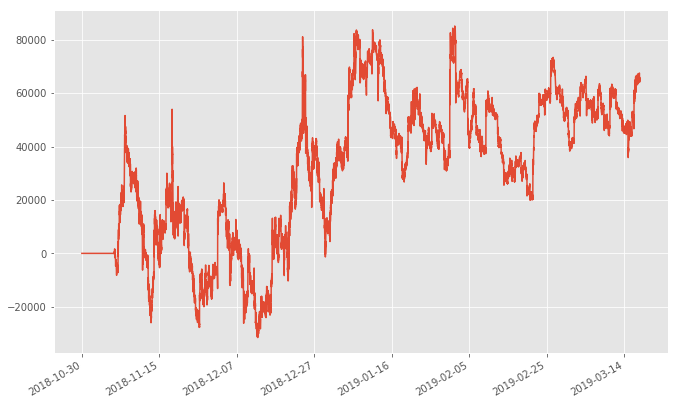

0.6869607785215986


In [24]:
mom = momentum_signal(prices, 2100)

pnl_mom = np.sum(mom * np.roll(ret1, -1, axis=0), axis=1) * principal
pnl_mom = np.nan_to_num(pnl_mom)

plt.style.use("ggplot")
formatter = MyFormatter(dates)
fig, ax = plt.subplots(figsize=(11, 7))
ax.xaxis.set_major_formatter(formatter)
ax.plot(np.arange(pnl_mom.shape[0]), np.cumsum(pnl_mom))
fig.autofmt_xdate()
plt.show()

print(annual_sharpe(pnl_mom))

### Study the effect of look back period (what is the best this strategy can get)

In [ ]:
res = []
t = time.time()
for i in range(1, 4000):
    mom_5 = momentum_signal(prices, i)
    pnl = np.sum(mom_5 * np.roll(ret1, -1, axis=0), axis=1) * principal
    pnl = np.nan_to_num(pnl)
    res.append(annual_sharpe(pnl))

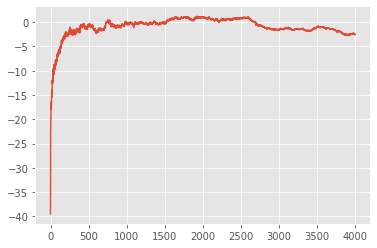

In [154]:
plt.plot(res)

# 2. Buy and Hold Strategy

In [8]:
price_data = prices.iloc[:, [2,4,6]].values

In [9]:
mut = ret1+1
mut[0] = 1

In [20]:
pnl_hold = np.sum((np.cumprod(mut, axis=0)-1) / 3 * principal, axis=1)
pnl_hold = pnl_hold - np.roll(pnl_hold, 1)
pnl_hold[0] = 0

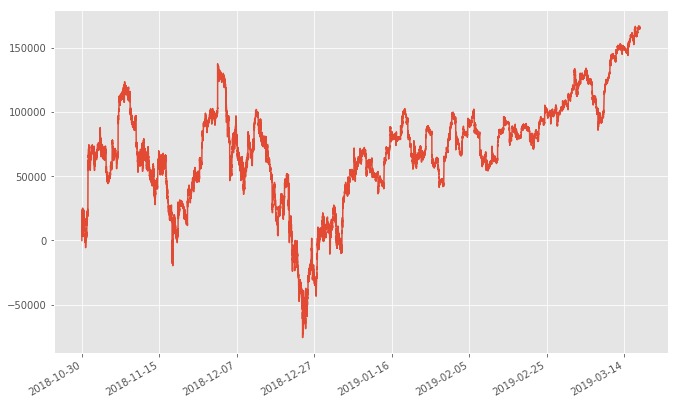

1.4030214749563588


In [21]:
plt.style.use("ggplot")
formatter = MyFormatter(dates)
fig, ax = plt.subplots(figsize=(11, 7))
ax.xaxis.set_major_formatter(formatter)
ax.plot(np.arange(pnl_hold.shape[0]), np.cumsum(pnl_hold))
fig.autofmt_xdate()
plt.show()

print(annual_sharpe(pnl_hold))

In [12]:
import pickle

In [18]:
with open("../equity/model_pnl.dms", "rb") as f:
    b = pickle.load(f)

In [19]:
b

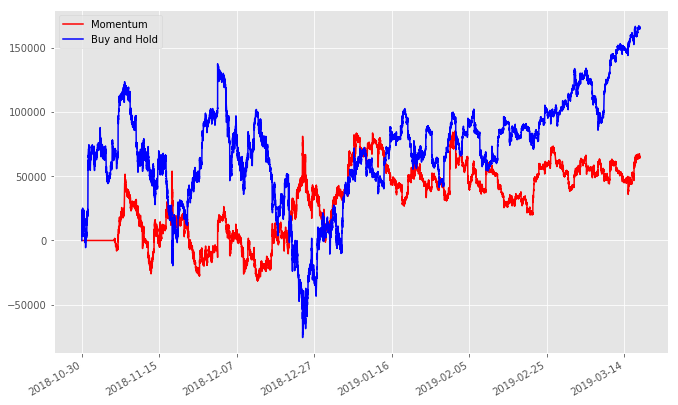

1.4030214749563588


In [27]:
plt.style.use("ggplot")
formatter = MyFormatter(dates)
fig, ax = plt.subplots(figsize=(11, 7))
ax.xaxis.set_major_formatter(formatter)
ax.plot(np.arange(pnl_mom.shape[0]), np.cumsum(pnl_mom), c="r", label="Momentum")
ax.plot(np.arange(pnl_hold.shape[0]), np.cumsum(pnl_hold), c="b", label="Buy and Hold")
fig.autofmt_xdate()
plt.legend()
plt.show()

print(annual_sharpe(pnl_hold))